## Modules

In [2]:
# Modules
import sys
sys.path.append("/home/simon/Documents/REPO/Exact_laws")
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_exactlaw/notebook")

from exact_laws.preprocessing.process_on_standard_h5_file import describ_file
from visualisation_tools import *
from exact_laws.mathematical_tools.derivation import cdiff

import os
from matplotlib import ticker, rc
import numpy as np
import json

In [3]:
# Matplotlib config
#%matplotlib widget
%matplotlib qt5
plt.rcParams['text.usetex'] = True
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('font', size=18)

numfig = 0

## Informations et données

In [4]:
simu_name = 'CGL1'
with open("/home/simon/Documents/REPO/Simu/descript_oca_simu.json","r") as f:
    simus = json.load(f)[simu_name]
#del(simus['10600'],simus['12500'],simus['12785'],simus['12800'],simus['12815'],)
times = list(simus.keys())
for t in times : 
    if not '6700.' in t: del(simus[t])
times = list(simus.keys())
simus_name= 'CGL1.6700'
print(simus[times[0]])

{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL1/CGL1_6700f/', 'cycle': 'cycle_0', 'group_grid': '3Dgrid', 'N': [512, 512, 512], 'kdi': 0.045454545454545456, 'theta': 1.4597608823983306, 'thrsh_forc_hi': 0.016, 'thrsh_forc_lo': 0.015, 'a1_forc': 0.5, 'act_forc': True, 'nu': 7.35e-08, 'eta': 7.35e-08, 'hdiss_rho': 0, 'hdiss_p': 7.35e-09, 'an_hd': 80, 'ap0': 1, 'B0': [0, 0, 1], 'beta0': 1, 'name': 'CGL1.6700.0000', 'EL_red1D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alli_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alleq_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_allinc_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_allkhm_EL_lincart_all_red1D.h5'], 'EL_red2D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL1.6700.0/OCA_CGL1.6700.0_alli_EL

In [5]:
# Paths 
path_record_images = f"./images_{simu_name}/"
if not os.path.exists(path_record_images) : os.mkdir(path_record_images)

In [6]:
# Paramètres
simu = f"{simu_name}"
kdi = simus[times[0]]['kdi'] # kperpdi = 2pidi/l => l/di = 2pi/(kdi)
theta = simus[times[0]]['theta']
lforc = np.array([(2*np.pi/kdi, 2*np.pi/kdi*np.tan(theta)),(2*np.pi/kdi/np.sqrt(2), 2*np.pi/kdi*np.tan(theta))]) # (lperp/di, lpar/di)
linert = (1,1)
print(lforc)

[[ 138.23007676 1239.79812481]
 [  97.74342464 1239.79812481]]


In [7]:
# Grille
grid = read_grid_in_h5file(simus[times[0]]['EL_red2D'][0])
c = grid['c']
axe_par = np.array(grid['lpar'])*grid['c'][2]
axe_perp = np.array(grid['lperp'])#*grid['c'][0]
label_par = "$\ell_{\parallel} / d_i$"
label_perp = "$\ell_{\perp}/ d_i$"
del(grid)
grid = read_grid_in_h5file(simus[times[0]]['EL_red1D'][0])
axe_l = np.array(grid['l'])
label_l = "$\ell / d_i$"
print(axe_par[1],axe_par[2],max(axe_par))
print(axe_perp[1],axe_perp[2],max(axe_perp))
print(axe_l[1],max(axe_l))

2.4214807125247577 4.842961425049515 617.4775816938132
0.2699806186678728 0.5399612373357456 68.84505776030757
0.2699806186678728 68.84505776030757


In [8]:
gridlp, gridlpar = np.meshgrid(axe_perp,axe_par, indexing='ij')
filt_45 = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))*180/np.pi
filt_45inf = np.where(filt_45<=45,1,np.nan)
filt_45sup = np.where(filt_45>=45,1,np.nan)
filt_45b = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))
filt_45binf = np.where(filt_45b<=theta,1,np.nan)
filt_45bsup = np.where(filt_45b>=theta,1,np.nan)
filt_perp10pc = np.where(gridlp<=lforc[1,0]*0.1,1,np.nan)
filt_par10pc = np.where(gridlpar<=lforc[1,1]*0.1,1,np.nan)
del(gridlp,gridlpar)

In [9]:
# liste des temps
dict_temps = {}
for t in times : 
    if '_R' in t : 
        dict_temps[t] = eval(t[:-2])
    else : 
        dict_temps[t] = eval(t)
temps =  sorted(dict_temps.items(), key=lambda t: t[1])
dt = temps[1][1] - temps[0][1]

## Lecture et assemblage de lois exactes

In [10]:
# Lecture fichiers et corrections
dict_quantities = {}
dict_quantities1D = {}
dict_coeffs = {}
quantities = {} 
quantities1D = {}  
coeffs = {}

for it,t in enumerate(simus.keys()):
    dict_quantities[t] = {}
    dict_coeffs[t] = {}
    for fstr in simus[t]['EL_red2D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities[t][k] = dqs[k] 
        for k in dcs.keys():
            dict_coeffs[t][k] = dcs[k]
            if "source_rbdd" in k:
                dict_coeffs[t][k] = -np.abs(dcs[k])
            if "ue" in k and not 'KHM' in k :
                dict_coeffs[t][k] = -np.abs(dcs[k])*1836
            if 'F3_flux' in k : 
                dict_coeffs[t]['SS22F3_div_flux_'+k[12:]] = dcs[k]
            if 'F3_source' in k:
                dict_coeffs[t][k] = np.abs(dcs[k])
    dict_coeffs[t]['COR_dt_cor_rvv'] = 1
    dict_coeffs[t]['COR_dt_cor_rbb'] = 1
    dict_coeffs[t]['COR_dt_cor_ru'] = 1
    dict_coeffs[t]['COR_dt_cor_rue'] = 1836
    dict_coeffs[t]['ICOR_dt_cor_vv'] = 1
    dict_coeffs[t]['ICOR_dt_cor_bb'] = 1
    
    dict_quantities1D[t] = {}
    for fstr in simus[t]['EL_red1D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities1D[t][k] = dqs[k] 
for q in dict_quantities[times[-1]].keys():
    quantities[q] = np.mean(np.array([dict_quantities[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_quantities1D[times[-1]].keys():
    quantities1D[q] = np.mean(np.array([dict_quantities1D[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_coeffs[times[-1]].keys():
    coeffs[q] = dict_coeffs[times[-1]][q]


In [11]:
# dt des quantitées
quantities_name = [k for k in quantities if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    for i in range(len(temps)):
        dict_quantities[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities['dt_'+q] = np.mean(dt_tab[1:-1],axis=0)

# dt des quantitées
quantities_name = [k for k in quantities1D if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities1D[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    if q == 'cor_rvv': print(dt_tab[0][0],dt_tab[1][0],dt_tab[1][0])
    for i in range(len(temps)):
        dict_quantities1D[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities1D['dt_'+q] = np.mean(dt_tab,axis=0)

-1.2844832393998917e-05 -1.2836495683454796e-05 -1.2836495683454796e-05


In [11]:
# Combinaisons de termes
dic_of_list_terms = {}
dic_of_list_terms['SS21_F1'] = ['SS21Iso_div_flux_drbdbdv', 'SS21Iso_div_flux_drbdvdb', 'SS21Iso_div_flux_drvdbdb', 'SS21Iso_div_flux_drvdvdv',]
dic_of_list_terms['SS21Ions_F2'] = ['SS21Iso_div_flux_drduisodv',]
dic_of_list_terms['SS21Ions_S'] = [k for k in coeffs if k.startswith('SS21Iso_') and k not in dic_of_list_terms['SS21_F1'] and k not in dic_of_list_terms['SS21Ions_F2']]
dic_of_list_terms['SS21Elec_F2'] = ['SS21Elec_div_flux_drduedv']
dic_of_list_terms['SS21Elec_S'] = ['SS21Elec_div_flux_drpev','SS21Elec_source_rduedv','SS21Elec_source_rpedv','SS21Elec_source_rvpedr']
dic_of_list_terms['SS21_F2'] = dic_of_list_terms['SS21Ions_F2'] + dic_of_list_terms['SS21Elec_F2']
dic_of_list_terms['SS21_S'] = dic_of_list_terms['SS21Ions_S'] + dic_of_list_terms['SS21Elec_S']
dic_of_list_terms['SS21_F'] = dic_of_list_terms['SS21_F1'] + dic_of_list_terms['SS21_F2']
dic_of_list_terms['SS21'] = dic_of_list_terms['SS21_F1'] + dic_of_list_terms['SS21_F2'] + dic_of_list_terms['SS21_S']
dic_of_list_terms['PP98'] = [k for k in coeffs if k.startswith('PP98_')]

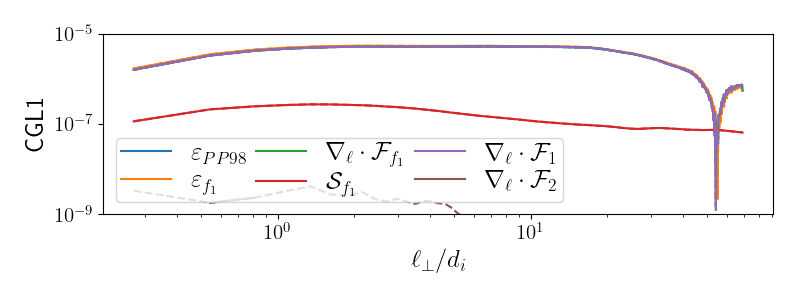

In [114]:
plt.figure('M2', figsize=(8,3))
plt.clf()
y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['PP98'])
splot(axe_perp[1:],np.nanmean(y1*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98}$') 
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21'])
splot(axe_perp[1:],np.nanmean(y2*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{f_1}$') 
#print(np.max((y2-y1)/y2))
#splot(axe_perp[1:],np.nanmean((y1-y2)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{f_1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{f_1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_S'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}_{f_1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F1'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F2'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{2}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-9,1e-5)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

/tmp/ipykernel_13346/534679259.py:4: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y1*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98}$')
/tmp/ipykernel_13346/534679259.py:6: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y2*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{f_1}$')
/tmp/ipykernel_13346/534679259.py:9: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{f_1}$')
/tmp/ipykernel_13346/534679259.py:11: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{S}_{f_1}$')
/tmp/ipykernel_13346/534679259.py:13: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{1}$')
/tmp/ipykernel_13346/534679259.py:15: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = 

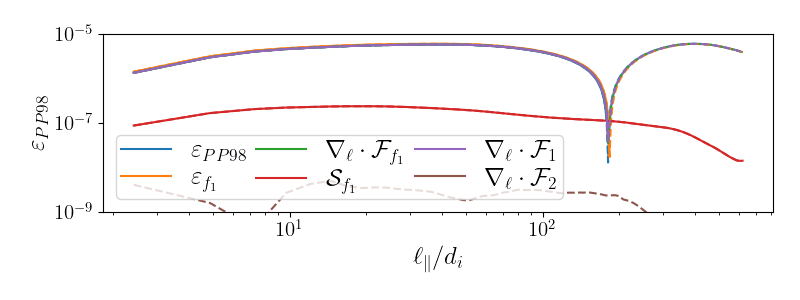

In [115]:
plt.figure('M3', figsize=(8,3))
plt.clf()
y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['PP98'])
splot(axe_par[1:],np.nanmean(y1*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98}$') 
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21'])
splot(axe_par[1:],np.nanmean(y2*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{f_1}$') 
#splot(axe_par[1:],np.nanmean((y2-y1)*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{f_1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{f_1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_S'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{S}_{f_1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F1'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{1}$') 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F2'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{2}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-9,1e-5)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\parallel}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

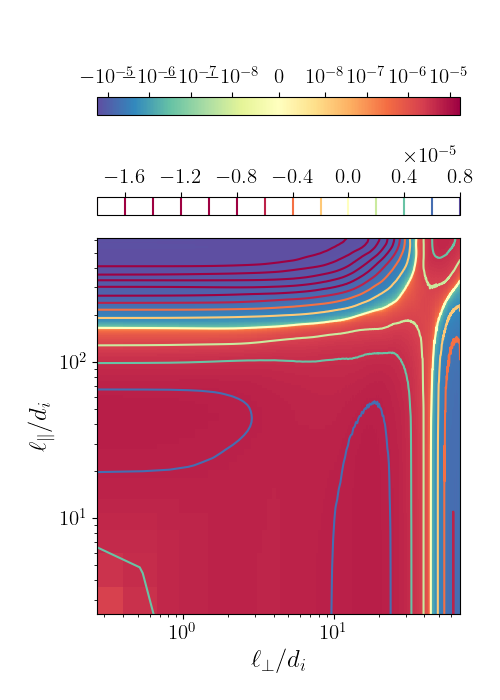

In [48]:
X,Y = np.meshgrid(axe_perp,axe_par)
Z = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21'])
plt.figure('M4', figsize=(5,7))
plt.clf()
#plt.title('$\\varepsilon_{f_1}$')
colormap = plt.pcolor(X,Y,np.transpose(Z), norm=colors.SymLogNorm(linthresh = 1e-8, vmin = - np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                   cmap='Spectral_r', shading='auto')
plt.colorbar(colormap,location='top')
contours = plt.contour(X,Y,np.transpose(Z),15,cmap='Spectral',vmin = - np.max(Z), vmax=np.max(Z))
#plt.clabel(contours, inline=False, fontsize=15,rightside_up=True,use_clabeltext =True,
           #manual=[(1,413),(1,320),(1,240),(1,167),(1,67),(0.5,12)])#fmt='%.1E',inline_spacing=1,
plt.colorbar(contours,location='top')
plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.ylim(axe_par[1],axe_par[-1])
plt.ylabel('$\ell_{\\parallel}/d_i$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.tight_layout()
plt.show()

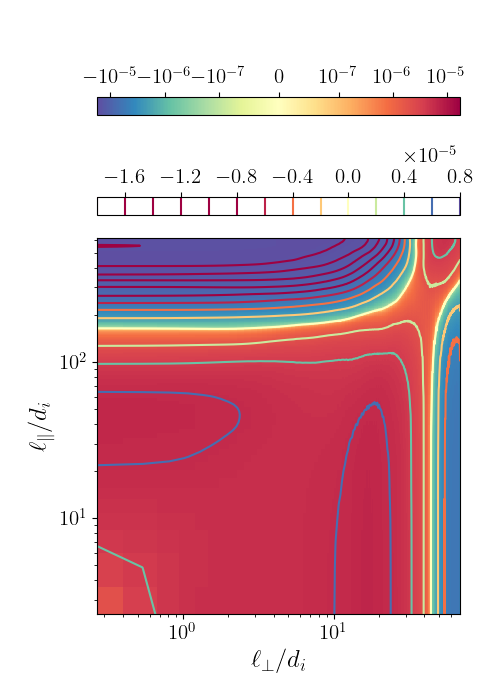

In [16]:
X,Y = np.meshgrid(axe_perp,axe_par)
Z = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_F'])
plt.figure('M5', figsize=(5,7))
plt.clf()
#plt.title('$\\nabla_{{\ell}} \\cdot \\mathcal{F}_{f_1}$')
colormap = plt.pcolor(X,Y,np.transpose(Z), norm=colors.SymLogNorm(linthresh = 1e-7, vmin = - np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                   cmap='Spectral_r', shading='auto')
plt.colorbar(colormap,location='top')
contours = plt.contour(X,Y,np.transpose(Z),15,cmap='Spectral',vmin = - np.max(Z), vmax=np.max(Z))
#plt.clabel(contours, inline=False, fontsize=15,rightside_up=True,use_clabeltext =True,
           #manual=[(1,413),(1,320),(1,240),(1,167),(1,67),(0.5,12)])#fmt='%.1E',inline_spacing=1,
plt.colorbar(contours,location='top')
plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.ylim(axe_par[1],axe_par[-1])
plt.ylabel('$\ell_{\\parallel}/d_i$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.tight_layout()
plt.show()

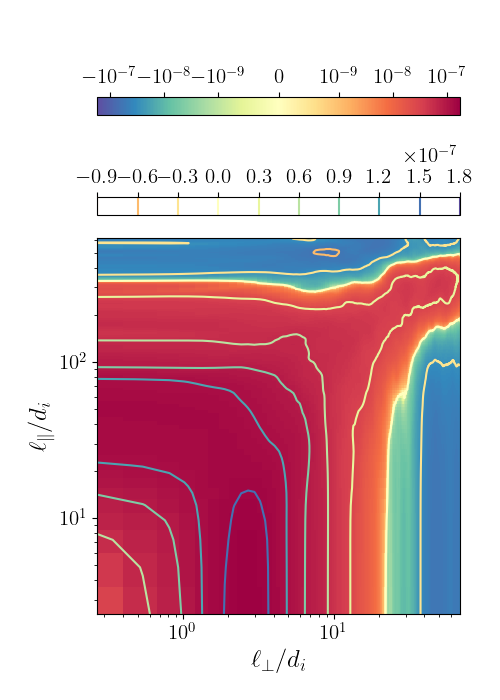

In [17]:
X,Y = np.meshgrid(axe_perp,axe_par)
Z = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21_S'])
plt.figure('M6', figsize=(5,7))
plt.clf()
#plt.title('$\\mathcal{S}_{f_1}$')
colormap = plt.pcolor(X,Y,np.transpose(Z), norm=colors.SymLogNorm(linthresh = 1e-9, vmin = - np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                   cmap='Spectral_r', shading='auto')
plt.colorbar(colormap,location='top')
contours = plt.contour(X,Y,np.transpose(Z),8,cmap='Spectral',vmin = - np.max(Z), vmax=np.max(Z))
#plt.clabel(contours, inline=False, fontsize=15,rightside_up=True,use_clabeltext =True,
           #manual=[(1,413),(1,320),(1,240),(1,167),(1,67),(0.5,12)])#fmt='%.1E',inline_spacing=1,
plt.colorbar(contours,location='top')
plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.ylim(axe_par[1],axe_par[-1])
plt.ylabel('$\ell_{\\parallel}/d_i$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.tight_layout()
plt.show()

In [117]:
dic_of_list_terms = {}
# Termes en pm dans A18
dic_of_list_terms['SS21Iso_pm'] = ['SS21Iso_div_flux_drpmv','SS21Iso_source_rvpmdr',
                                   'SS21Iso_source_rbdbdv','SS21Iso_source_drbbdv']
dic_of_list_terms['SS21Iso_pm_SH'] = ['SS21Iso_div_flux_drpmv']
dic_of_list_terms['SS21Iso_pm_Sc'] = ['SS21Iso_source_rbdbdv','SS21Iso_source_drbbdv']
dic_of_list_terms['SS21Iso_pm_Mbeta'] = ['SS21Iso_source_rvpmdr']

# Termes en pm dans SS22
dic_of_list_terms['SS22Iso_pm'] = ['SS22Iso_div_flux_drdpmdv','SS22Iso_source_pmvdrdr','SS22Iso_source_rvdpmdr',
                                   'SS22Iso_source_bdrbdv','SS22Iso_source_rbdbdv']
dic_of_list_terms['SS22Iso_pm_flux'] = ['SS22Iso_div_flux_drdpmdv']
dic_of_list_terms['SS22Iso_pm_sources'] = ['SS22Iso_source_pmvdrdr','SS22Iso_source_rvdpmdr',
                                   'SS22Iso_source_bdrbdv','SS22Iso_source_rbdbdv']

# Termes en p dans A18
dic_of_list_terms['SS21Iso_p'] = ["SS21Iso_div_flux_drpisov",
                                  "SS21Iso_source_rpisodv",'SS21Iso_source_rvpisodr']
dic_of_list_terms['SS21Iso_p_SH'] = ["SS21Iso_div_flux_drpisov",]
dic_of_list_terms['SS21Iso_p_SHiso'] = ["SS21Iso_source_rpisodv",]
dic_of_list_terms['SS21Iso_p_Mu'] = ['SS21Iso_source_rvpisodr',]

# Termes en p dans SS22
dic_of_list_terms['SS22Iso_p'] = ['SS22Iso_div_flux_drdpisodv',
                                  'SS22Iso_source_rdpisodv',
                                  'SS22Iso_source_pisovdrdr','SS22Iso_source_rvdpisodr']
dic_of_list_terms['SS22Iso_p_flux'] = ['SS22Iso_div_flux_drdpisodv']
dic_of_list_terms['SS22Iso_p_sources'] = ['SS22Iso_source_rdpisodv',
                                  'SS22Iso_source_pisovdrdr','SS22Iso_source_rvdpisodr']


# Termes en p dans A18
dic_of_list_terms['SS21IsoE_p'] = ["SS21Elec_div_flux_drpev",
                                  "SS21Elec_source_rpedv",'SS21Elec_source_rvpedr']
dic_of_list_terms['SS21IsoE_p_SH'] = ["SS21Elec_div_flux_drpev",]
dic_of_list_terms['SS21IsoE_p_SHiso'] = ["SS21Elec_source_rpedv",]
dic_of_list_terms['SS21IsoE_p_Mu'] = ['SS21Elec_source_rvpedr',]

# Termes en p dans SS22
dic_of_list_terms['SS22IsoE_p'] = ['SS22Elec_div_flux_drdpedv',
                                  'SS22Elec_source_rdpedv',
                                  'SS22Elec_source_pevdrdr','SS22Elec_source_rvdpedr']
dic_of_list_terms['SS22IsoE_p_flux'] = ['SS22Elec_div_flux_drdpedv']
dic_of_list_terms['SS22IsoE_p_sources'] = ['SS22Elec_source_rdpedv',
                                  'SS22Elec_source_pevdrdr','SS22Elec_source_rvdpedr']


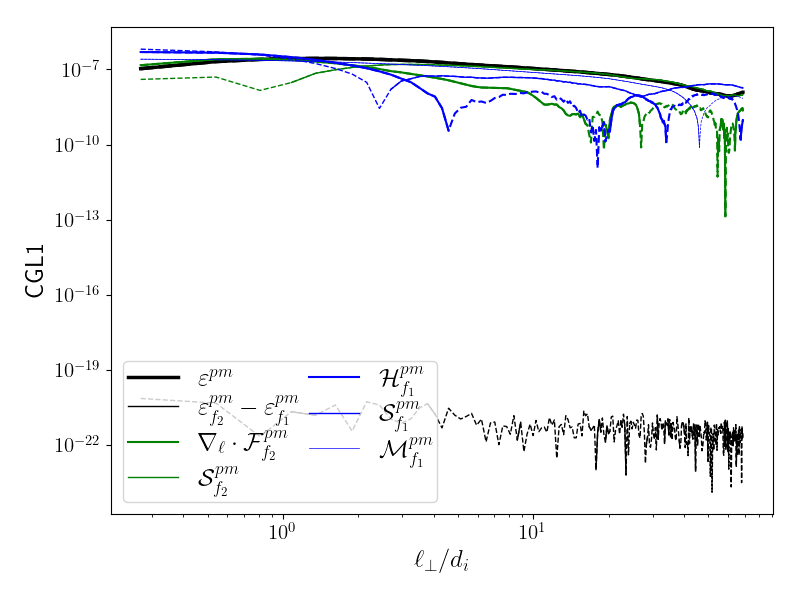

In [119]:
plt.figure('F1', figsize=(8,6))
plt.clf()
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{pm}$',color='k',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm'])-linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{pm}_{f_2}-\\varepsilon^{pm}_{f_1}$',color='k',linewidth=1) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{pm}_{f_2}$',color='g',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\mathcal{S}^{pm}_{f_2}$',color='g',linewidth=1) 
#y = 
#splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{pm}_{f_1}$',color='b',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm_SH'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{H}^{pm}_{f_1}$',color='b',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm_Sc'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{pm}_{f_1}$',color='b',linewidth=1) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm_Mbeta'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{M}^{pm}_{f_1}$',color='b',linewidth=0.5) 

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

/tmp/ipykernel_79450/4085418288.py:4: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\varepsilon^{pm}_{f_1}$',color='b',linewidth=2.5)
/tmp/ipykernel_79450/4085418288.py:6: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{H}^{pm}_{f_1}$',color='b',linewidth=1.5)
/tmp/ipykernel_79450/4085418288.py:8: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{S}^{pm}_{f_1}$',color='b',linewidth=1)
/tmp/ipykernel_79450/4085418288.py:10: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{M}^{pm}_{f_1}$',color='b',linewidth=0.5)
/tmp/ipykernel_79450/4085418288.py:12: RuntimeWarning: Mean of empty slice
  splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\varepsilon^{pm}_{f_2}$',color='g',linewidth=2.5)
/tmp/ipykernel_79450/4085418288.py:14: R

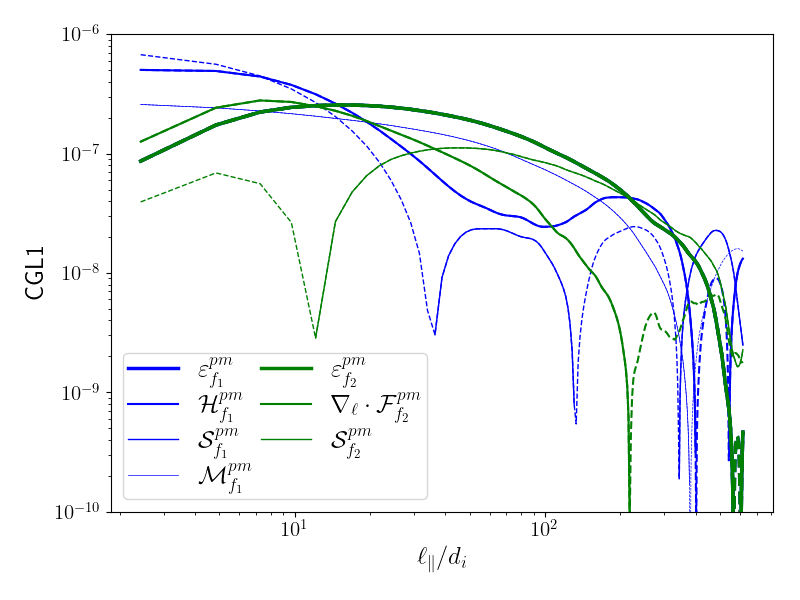

In [42]:
plt.figure('F1p', figsize=(8,6))
plt.clf()
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\varepsilon^{pm}_{f_1}$',color='b',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm_SH'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{H}^{pm}_{f_1}$',color='b',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm_Sc'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{S}^{pm}_{f_1}$',color='b',linewidth=1) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_pm_Mbeta'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\mathcal{M}^{pm}_{f_1}$',color='b',linewidth=0.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\varepsilon^{pm}_{f_2}$',color='g',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm_flux'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{pm}_{f_2}$',color='g',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_pm_sources'])
splot(axe_par[1:],np.nanmean(y*filt_45bsup,axis=0)[1:],label = '$\mathcal{S}^{pm}_{f_2}$',color='g',linewidth=1) 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\parallel}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

IndexError: list index out of range

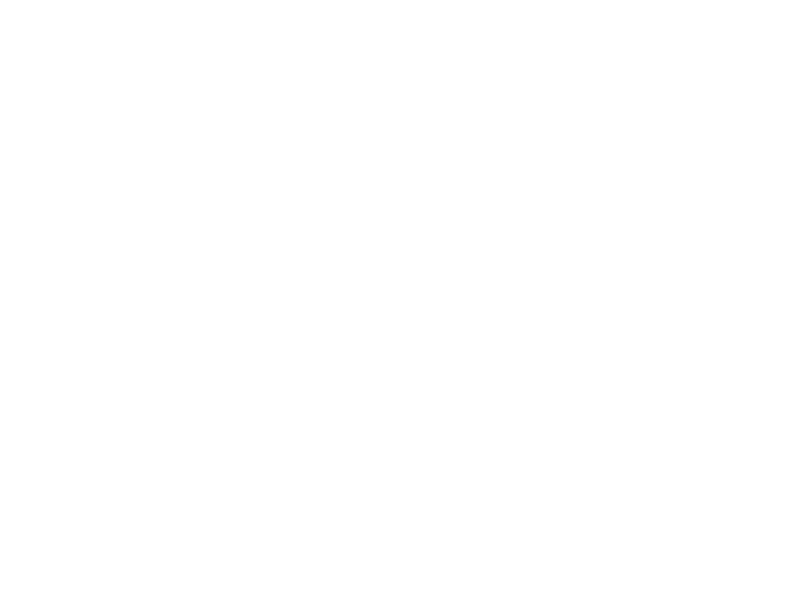

In [62]:
plt.figure('F2', figsize=(8,6))
plt.clf()
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_p']+dic_of_list_terms['SS22IsoE_p'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{p}$',color='k',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_p_flux']+dic_of_list_terms['SS22IsoE_p_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{p}_{f_2}$',color='g',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22Iso_p_sources']+dic_of_list_terms['SS22IsoE_p_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\mathcal{S}^{p}_{f_2}$',color='g',linewidth=1) 
# y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_p']+dic_of_list_terms['SS21IsoE_p'])
# splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{p}_{f_1}$',color='b',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_p_SH']+dic_of_list_terms['SS21IsoE_p_SH'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{H}^{p}_{f_1}$',color='b',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_p_SHiso']+dic_of_list_terms['SS21IsoE_p_SHiso'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{p}_{f_1}$',color='b',linewidth=1) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21Iso_p_Mu']+dic_of_list_terms['SS21IsoE_p_Mu'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{M}^{p}_{f_1}$',color='b',linewidth=0.5) 

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10,2e-7)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

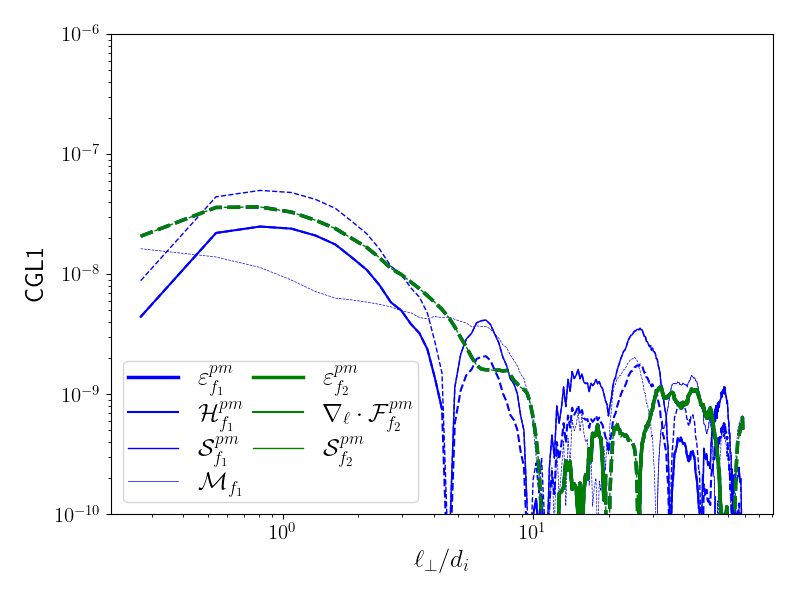

In [36]:
plt.figure('F3', figsize=(8,6))
plt.clf()
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21IsoE_p'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{pm}_{f_1}$',color='b',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21IsoE_p_SH'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{H}^{pm}_{f_1}$',color='b',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21IsoE_p_SHiso'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{pm}_{f_1}$',color='b',linewidth=1) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS21IsoE_p_Mu'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{M}_{f_1}$',color='b',linewidth=0.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22IsoE_p'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{pm}_{f_2}$',color='g',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22IsoE_p_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{pm}_{f_2}$',color='g',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22IsoE_p_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\mathcal{S}^{pm}_{f_2}$',color='g',linewidth=1) 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [179]:
dic_of_list_terms = {}
# Termes en pm dans f2
dic_of_list_terms['SS22F2_pm'] = ['SS22Iso_div_flux_drdpmdv','SS22Iso_source_pmvdrdr','SS22Iso_source_rvdpmdr']
dic_of_list_terms['SS22F2_pm_flux'] = ['SS22Iso_div_flux_drdpmdv']
dic_of_list_terms['SS22F2_pm_sources'] = ['SS22Iso_source_pmvdrdr','SS22Iso_source_rvdpmdr']

# Termes en p dans f2
dic_of_list_terms['SS22F2_p'] = ['SS22Iso_div_flux_drdpisodv','SS22Iso_source_pisovdrdr','SS22Iso_source_rvdpisodr']
dic_of_list_terms['SS22F2_p_flux'] = ['SS22Iso_div_flux_drdpisodv']
dic_of_list_terms['SS22F2_p_sources'] = ['SS22Iso_source_pisovdrdr','SS22Iso_source_rvdpisodr']

# Termes en p dans f2
dic_of_list_terms['SS22F2_pan'] = ['SS22Gyr_div_flux_drdpandv','SS22Gyr_source_panvdrdr','SS22Gyr_source_rvdpandr']
dic_of_list_terms['SS22F2_pan_flux'] = ['SS22Gyr_div_flux_drdpandv']
dic_of_list_terms['SS22F2_pan_sources'] = ['SS22Gyr_source_panvdrdr','SS22Gyr_source_rvdpandr']

# Termes en pe dans f2
dic_of_list_terms['SS22F2_pe'] = ['SS22Elec_div_flux_drdpedv','SS22Elec_source_pevdrdr','SS22Elec_source_rvdpedr']
dic_of_list_terms['SS22F2_pe_flux'] = ['SS22Elec_div_flux_drdpedv']
dic_of_list_terms['SS22F2_pe_sources'] = ['SS22Elec_source_pevdrdr','SS22Elec_source_rvdpedr']

dic_of_list_terms['SS22F2_P'] = dic_of_list_terms['SS22F2_pm'] + dic_of_list_terms['SS22F2_p'] + dic_of_list_terms['SS22F2_pe'] + dic_of_list_terms['SS22F2_pan']
dic_of_list_terms['SS22F2_P_flux'] = dic_of_list_terms['SS22F2_pm_flux'] + dic_of_list_terms['SS22F2_p_flux'] + dic_of_list_terms['SS22F2_pe_flux'] + dic_of_list_terms['SS22F2_pan_flux']
dic_of_list_terms['SS22F2_P_sources'] = dic_of_list_terms['SS22F2_pm_sources'] + dic_of_list_terms['SS22F2_p_sources'] + dic_of_list_terms['SS22F2_pe_sources'] + dic_of_list_terms['SS22F2_pan_sources']

# Termes en pm dans f3
dic_of_list_terms['SS22F3_pm'] = ['SS22F3_div_flux_drdpmdrv','SS22F3_source_rvdrpmdr']
dic_of_list_terms['SS22F3_pm_flux'] = ['SS22F3_div_flux_drdpmdrv']
dic_of_list_terms['SS22F3_pm_sources'] = ['SS22F3_source_rvdrpmdr']

# Termes en pm dans f3
dic_of_list_terms['SS22F3_p'] = ['SS22F3_div_flux_drdpisodrv','SS22F3_source_rvdrpisodr']
dic_of_list_terms['SS22F3_p_flux'] = ['SS22F3_div_flux_drdpisodrv']
dic_of_list_terms['SS22F3_p_sources'] = ['SS22F3_source_rvdrpisodr']

# Termes en pm dans f3
dic_of_list_terms['SS22F3_pe'] = ['SS22F3_div_flux_drdpedrv','SS22F3_source_rvdrpedr']
dic_of_list_terms['SS22F3_pe_flux'] = ['SS22F3_div_flux_drdpedrv']
dic_of_list_terms['SS22F3_pe_sources'] = ['SS22F3_source_rvdrpedr']

# Termes en pm dans f3
dic_of_list_terms['SS22F3_pan'] = ['SS22F3_div_flux_drdpandrv','SS22F3_source_rvdrpandr']
dic_of_list_terms['SS22F3_pan_flux'] = ['SS22F3_div_flux_drdpandrv']
dic_of_list_terms['SS22F3_pan_sources'] = ['SS22F3_source_rvdrpandr']

dic_of_list_terms['SS22F3_P'] = dic_of_list_terms['SS22F3_pm'] + dic_of_list_terms['SS22F3_p'] + dic_of_list_terms['SS22F3_pe'] + dic_of_list_terms['SS22F3_pan']
dic_of_list_terms['SS22F3_P_flux'] = dic_of_list_terms['SS22F3_pm_flux'] + dic_of_list_terms['SS22F3_p_flux'] + dic_of_list_terms['SS22F3_pe_flux'] + dic_of_list_terms['SS22F3_pan_flux']
dic_of_list_terms['SS22F3_P_sources'] = dic_of_list_terms['SS22F3_pm_sources'] + dic_of_list_terms['SS22F3_p_sources'] + dic_of_list_terms['SS22F3_pe_sources'] + dic_of_list_terms['SS22F3_pan_sources']

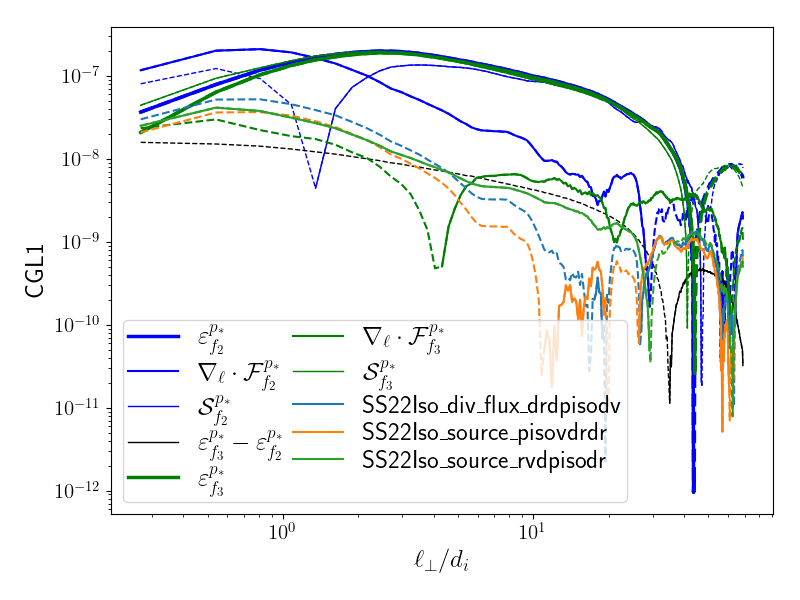

In [185]:
plt.figure('F4', figsize=(8,6))
plt.clf()

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F2_P'])
splot(axe_perp[1:],np.nanmean(y1*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{p_*}_{f_2}$',color='b',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F2_P_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{p_*}_{f_2}$',color='b',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F2_P_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{p_*}_{f_2}$',color='b',linewidth=1) 
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F3_P'])
splot(axe_perp[1:],np.nanmean((y2-y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{p_*}_{f_3}-\\varepsilon^{p_*}_{f_2}$',color='k',linewidth=1) 
splot(axe_perp[1:],np.nanmean(y2*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{p_*}_{f_3}$',color='g',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F3_P_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{p_*}_{f_3}$',color='g',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F3_P_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{p_*}_{f_3}$',color='g',linewidth=1) 

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [102]:
plt.figure('F4', figsize=(8,6))
plt.clf()

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F2_p'])
splot(axe_perp[1:],np.nanmean(y1*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{p}_{f_2}$',color='b',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F2_p_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{p}_{f_2}$',color='b',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F2_p_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{p}_{f_2}$',color='b',linewidth=1) 
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F3_p'])
splot(axe_perp[1:],np.nanmean(y2*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{p}_{f_3}$',color='g',linewidth=2.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F3_p_flux'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\nabla_{\ell} \cdot \mathcal{F}^{p}_{f_3}$',color='g',linewidth=1.5) 
y = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['SS22F3_p_sources'])
splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{p}_{f_3}$',color='g',linewidth=1) 
splot(axe_perp[1:],np.nanmean((y2-y1)*filt_45binf,axis=1)[1:],label = '$\\mathcal{S}^{p}_{f_3}$',color='k',linewidth=1) 
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

KeyError: 'SS22F2_p'

In [12]:
dic_of_list_terms = {}
dic_of_list_terms['ELcgl'] = [k for k in coeffs if k.startswith('SS22Gyr')]
dic_of_list_terms['ELelec']  =  ['SS22Elec_div_flux_drduedv','SS22Elec_div_flux_drdpedv',
                               'SS22Elec_source_pevdrdr','SS22Elec_source_rdpedv',
                               'SS22Elec_source_rduedv','SS22Elec_source_rvdpedr']
dic_of_list_terms['ELhall'] = [k for k in coeffs if k.startswith('Hallcor')]
dic_of_list_terms['EL'] = dic_of_list_terms['ELcgl'] + dic_of_list_terms['ELelec'] + dic_of_list_terms['ELhall']
dic_of_list_terms['dtR'] = [k for k in coeffs if k.startswith('COR')]
dic_of_list_terms['khm'] = [k for k in coeffs if k.startswith('SS22KHM')]
print(dic_of_list_terms['khm'])


['SS22KHM_diss_b', 'SS22KHM_diss_rb', 'SS22KHM_diss_rue', 'SS22KHM_diss_rugyr', 'SS22KHM_diss_rv', 'SS22KHM_diss_ugyr', 'SS22KHM_diss_v', 'SS22KHM_forc_v']


In [43]:
yel1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
print(yel1[0,0])
yf = quantities['forc_v']/4
print(yf[0,0])
yd1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['khm'])-yf
print(yd1[0,0])
yt =  linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['dtR'])
print(yt[0,0])
print((yf-yt)[0,0])

1.4971479255009554e-07
1.5234654168330088e-05
-5.294913729900984e-06
9.330017181647239e-06
5.904636986682849e-06


In [ ]:
plt.figure('F4', figsize=(8,6))
plt.clf()

 
yf = quantities['forc_v']/4
splot(axe_perp[1:],np.nanmean(yf*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F}$') 

In [24]:
plt.figure('F4', figsize=(10,5))
plt.clf()

# yel1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
# splotold(axe_perp[1:],np.nanmean(yel1*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{NL}$') 
yf = quantities['forc_v']/4
# splotold(axe_perp[1:],np.nanmean(yf*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F}$') 
# yd1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['khm'])-yf
# splotold(axe_perp[1:],np.nanmean(yd1*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{D}$') 
# # yd2 =  - quantities['diss_v']/4 - quantities['diss_b']/4
# # splot(axe_perp[1:],np.nanmean(yd2*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{D}(Dv + DvA)$') 
# yt =  linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['dtR'])
# splotold(axe_perp[1:],np.nanmean(yt*filt_45binf,axis=1)[1:],label = '$\\partial_t \mathcal{R}$')
# yref = -yt+yf+yd1
# splotold(axe_perp[1:],np.nanmean(yref*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{ref}$') 
# zeta = yref-yel1
# splotold(axe_perp[1:],np.nanmean(zeta*filt_45binf,axis=1)[1:],label = '$\\zeta$')  
# zeta = yf-yt
# splot(axe_perp[1:],np.nanmean(zeta*filt_45binf,axis=1)[1:],label = '$\\zeta$')  
# yref = -yt+yf+yd2
# splot(axe_perp[1:],np.nanmean(yref*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{ref}$') 
# zeta = yref-yel1
# splot(axe_perp[1:],np.nanmean(zeta*filt_45binf,axis=1)[1:],label = '$\\zeta$') 
yd1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['khm'])-yf
splotold(axe_perp[1:],np.nanmean(yd1*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{D}$',color='k')  
labels = ['$\\varepsilon^m_{D}(D_{v_A})$','$\\varepsilon^m_{D}(D_{\\rho})$',
          '$\\varepsilon^{ue}_{D}(D_{\\rho})$','$\\varepsilon^{ui}_{D}(D_{\\rho})$',
          '$\\varepsilon^c_{D}(D_{\\rho})$','$\\varepsilon^{ui}_{D}(D_{u})$',
          '$\\varepsilon^c_{D}(D_{v})$','$\\varepsilon_{F}$']
for i, t in enumerate(dic_of_list_terms['khm'][:-1]) : 
    y = linear_op_from_list_term(coeffs,quantities,[t])
    splotold(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = labels[i])  

# plt.plot(axe_l[1:],1e-7* axe_l[1:]**(-2),'-.')
    
# labels = ['$\\partial_t \mathcal{R}_c$','$\\partial_t \mathcal{R}_m$',
#           '$\\partial_t \mathcal{R}_{ui}$','$\\partial_t \mathcal{R}_{ue}$',]
# for i, t in enumerate(dic_of_list_terms['dtR']) : 
#     y = linear_op_from_list_term(coeffs,quantities,[t])
#     splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = labels[i])  
    
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [15]:
plt.figure('F4', figsize=(10,5))
plt.clf()

yel1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
yf = yel1[0,0]-yel1
splotold(axe_perp[1:],np.nanmean(yel1*filt_45binf,axis=1)[1:],label = '$\\mathcal{E}_{NL}$') 
yf = linear_op_from_list_term(coeffs,quantities,['SS22KHM_forc_v',])
yf = yf[0,0]-yf
splotold(axe_perp[1:],np.nanmean(yf*filt_45binf,axis=1)[1:],label = '$\\mathcal{E}_{F}$') 
yd1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['khm'])-yf
yf = yd1[0,0]-yd1
splotold(axe_perp[1:],np.nanmean(yd1*filt_45binf,axis=1)[1:],label = '$\\mathcal{E}_{D}$') 
# yd2 =  - quantities['diss_v']/4 - quantities['diss_b']/4
# splot(axe_perp[1:],np.nanmean(yd2*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{D}(Dv + DvA)$') 
yt =  linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['dtR'])[0,0] - linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['dtR'])
yf = yt[0,0]-yt
splotold(axe_perp[1:],np.nanmean(yt*filt_45binf,axis=1)[1:],label = '$\\partial_t \mathcal{S}$')
yref = -yt+yf+yd1
splotold(axe_perp[1:],np.nanmean(yref*filt_45binf,axis=1)[1:],label = '$\\mathcal{E}_{ref}$') 
zeta = yref-yel1
splotold(axe_perp[1:],np.nanmean(zeta*filt_45binf,axis=1)[1:],label = '$\\mathcal{Z}$')  
# zeta = yf-yt
# splot(axe_perp[1:],np.nanmean(zeta*filt_45binf,axis=1)[1:],label = '$\\zeta$')  
# yref = -yt+yf+yd2
# splot(axe_perp[1:],np.nanmean(yref*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{ref}$') 
# zeta = yref-yel1
# # splot(axe_perp[1:],np.nanmean(zeta*filt_45binf,axis=1)[1:],label = '$\\zeta$')  
# labels = ['$\\mathcal{E}^m_{D}(D_{v_A})$','$\\mathcal{E}^m_{D}(D_{\\rho})$',
#           '$\\mathcal{E}^{ue}_{D}(D_{\\rho})$','$\\mathcal{E}^{ui}_{D}(D_{\\rho})$',
#           '$\\mathcal{E}^c_{D}(D_{\\rho})$','$\\mathcal{E}^{ui}_{D}(D_{u})$',
#           '$\\mathcal{E}^c_{D}(D_{v})$','$\\mathcal{E}_{F}$']
# for i, t in enumerate(dic_of_list_terms['khm'][:-1]) : 
#     y = linear_op_from_list_term(coeffs,quantities,[t])[0,0] - linear_op_from_list_term(coeffs,quantities,[t])
#     splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = labels[i])  
    
# labels = ['$\\partial_t \mathcal{S}_c$','$\\partial_t \mathcal{S}_m$',
#           '$\\partial_t \mathcal{S}_{ui}$','$\\partial_t \mathcal{S}_{ue}$',]
# for i, t in enumerate(dic_of_list_terms['dtR']) : 
#     y = linear_op_from_list_term(coeffs,quantities,[t])[0,0] - linear_op_from_list_term(coeffs,quantities,[t])
#     splot(axe_perp[1:],np.nanmean(y*filt_45binf,axis=1)[1:],label = labels[i])  
# yt =  linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['dtR'])[0,0] - linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['dtR'])
# yf = yt[0,0]-yt
# splot(axe_perp[1:],np.nanmean(yt*filt_45binf,axis=1)[1:],label = '$\\partial_t \mathcal{S}$',color='k')    

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-10,1e-6)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [153]:
for k in coeffs : 
    if k.startswith('SS22KHM'): print (k,coeffs[k])

SS22KHM_diss_b -0.25
SS22KHM_diss_rb -0.25
SS22KHM_diss_rue -0.25
SS22KHM_diss_rugyr -0.25
SS22KHM_diss_rv -0.25
SS22KHM_diss_ugyr -0.5
SS22KHM_diss_v -0.25
SS22KHM_forc_v 0.25
